In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 解决绘图中文显示问题 (可选)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial'] 
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 1. 读取与清洗数据 (Data Loading & Cleaning)

file_path = "Final_Features_Fixed.csv" 
df = pd.read_csv(file_path)

# 定义特征列和目标列
feature_cols = [
    'X1_SoftSeg', 'X2_DA_Content', 'X3_HardSeg', 'X4_R_Ratio', 'X5_Crosslink', 
    'DA_strategy', 'cross_class', 'healing_temperature', 'healing_time'
]
target_cols = ['tensile_strength', 'elongation', 'healing_eff']

# 1.1 数据清洗函数：处理非数值字符 (如 "侧链:1" -> 1)
def clean_value(val):
    if pd.isna(val): return np.nan
    val_str = str(val)
    # 如果包含中文或特殊字符，尝试提取数字
    import re
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", val_str)
    if nums:
        return float(nums[0])
    return np.nan

# 1.2 应用清洗
# 对所有特征列和目标列进行清洗，确保全是数字
cols_to_clean = feature_cols + target_cols
for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].apply(clean_value)

print("数据概览 (前5行):")
print(df[feature_cols + target_cols].head())
print("\n有效样本数:", len(df))

数据概览 (前5行):
   X1_SoftSeg  X2_DA_Content  X3_HardSeg  X4_R_Ratio  X5_Crosslink  \
0        0.67           0.04        0.33        1.33      0.000333   
1        0.64           0.05        0.36        1.38      0.000397   
2        0.61           0.05        0.39        1.43      0.000456   
3        0.56           0.00        0.44        1.00      0.000246   
4        0.56           0.00        0.44        1.00      0.000246   

   DA_strategy  cross_class  healing_temperature  healing_time  \
0          0.0          1.0                100.0          24.0   
1          0.0          1.0                100.0          24.0   
2          0.0          1.0                100.0          24.0   
3          0.0          1.0                130.0          48.0   
4          0.0          1.0                130.0          48.0   

   tensile_strength  elongation  healing_eff  
0              19.5      1039.7         90.0  
1              28.6       717.3          0.0  
2              45.0       567

In [4]:
# 2. 通用训练评估函数 (GPR + LOOCV)

def train_eval_model(task_name, target_col, input_features, data, model_type='GPR'):
    # 1. 剔除该目标值缺失的样本
    df_train = data.dropna(subset=[target_col] + input_features).copy()
    
    if len(df_train) < 5:
        print(f"[{task_name}] 样本太少 ({len(df_train)}), 跳过。")
        return
    
    X = df_train[input_features].values
    y = df_train[target_col].values
    
    # 2. 数据标准化 (对 GPR 至关重要)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. 模型定义
    if model_type == 'GPR':
        # 核函数：常数核 * RBF核 + 白噪声核 (处理实验误差)
        kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
        model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
    elif model_type == 'RF':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        
    # 4. 留一法交叉验证 (LOOCV)
    # 每次取1个样本做测试，其余做训练，循环N次
    y_pred = cross_val_predict(model, X_scaled, y, cv=LeaveOneOut())
    
    # 5. 评估指标
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    print(f"\n=== 任务: {task_name} ({model_type}) ===")
    print(f"样本数: {len(y)}")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    # 6. 绘图
    plt.figure(figsize=(5, 5))
    plt.scatter(y, y_pred, alpha=0.7, c='blue')
    # 画对角线
    min_val, max_val = min(y.min(), y_pred.min()), max(y.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel(f'Measured {target_col}')
    plt.ylabel(f'Predicted {target_col}')
    plt.title(f'{task_name} (R2={r2:.2f})')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    # 7. 如果是随机森林，输出特征重要性
    if model_type == 'RF':
        model.fit(X_scaled, y) # 全量训练一次以获取重要性
        

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("特征重要性排序:")
        for f in range(X.shape[1]):
            print("%d. %s (%f)" % (f + 1, input_features[indices[f]], importances[indices[f]]))
        
        # 画特征重要性图
        plt.figure(figsize=(8, 4))
        plt.title(f"Feature Importances ({task_name})")
        plt.bar(range(X.shape[1]), importances[indices], align="center")
        plt.xticks(range(X.shape[1]), [input_features[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


=== 任务: 拉伸强度预测 (GPR) ===
样本数: 86
R2 Score: 0.3768
RMSE: 11.1710


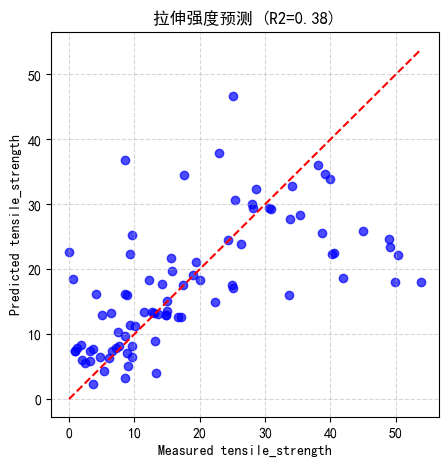


=== 任务: 断裂伸长率预测 (GPR) ===
样本数: 86
R2 Score: 0.3526
RMSE: 240.0737


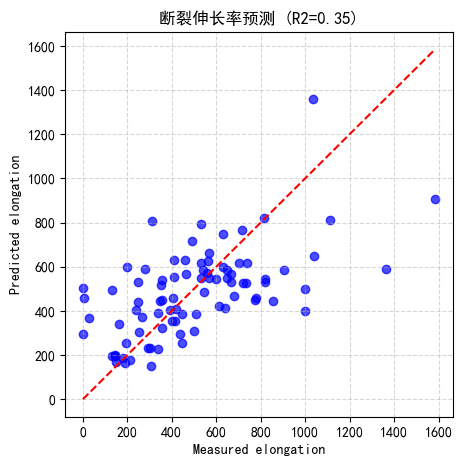


=== 任务: 自愈合效率预测 (GPR) ===
样本数: 86
R2 Score: 0.5696
RMSE: 25.3817


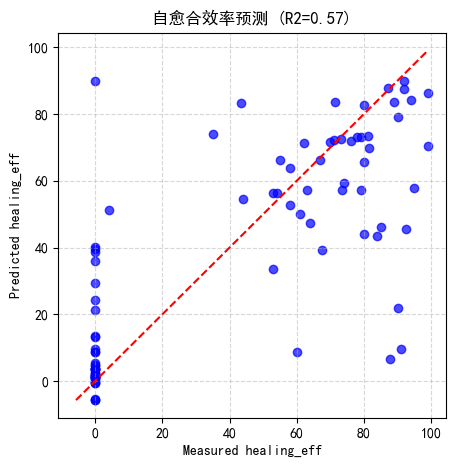

In [5]:
#3. 执行预测任务

# 任务 A: 预测拉伸强度 (Tensile Strength)
# 特征：不包含愈合温度/时间 (通常力学性能只与配方结构有关)
features_mech = ['X1_SoftSeg', 'X2_DA_Content', 'X3_HardSeg', 'X4_R_Ratio', 'X5_Crosslink', 'DA_strategy', 'cross_class']
train_eval_model("拉伸强度预测", 'tensile_strength', features_mech, df, model_type='GPR')
# train_eval_model("拉伸强度特征分析", 'tensile_strength', features_mech, df, model_type='RF') #以此查看特征重要性

# 任务 B: 预测断裂伸长率 (Elongation)
train_eval_model("断裂伸长率预测", 'elongation', features_mech, df, model_type='GPR')

# 任务 C: 预测自愈合效率 (Healing Efficiency)
# 特征：包含愈合温度和时间
features_heal = features_mech + ['healing_temperature', 'healing_time']
train_eval_model("自愈合效率预测", 'healing_eff', features_heal, df, model_type='GPR')